# First Iteration of the Solution

In [15]:
API_KEY = "9b1db8ecdf455c71e9d97b2ba4c8e3cc6dbfcc1e2ffc3b92fd5c5c5777f92796798d6ef2bdc53aebc6da1fe7b205a6dc35114382f3172a9d167469d824539767"

In [27]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
import time

# Function to perform polynomial multiplication (optimized for fewer qubits)
def polynomial_multiplication(qc, a, b, result):
    for i in range(len(a)):
        for j in range(len(b)):
            if i + j < len(result):
                qc.cx(a[i], result[i + j])

# Function to perform modular reduction
def modular_reduction(qc, poly, mod):
    for i in range(len(poly) - len(mod) + 1):
        if poly[i] == 1:
            for j in range(len(mod)):
                qc.cx(poly[i + j], mod[j])

# Function to perform multiplicative inverse in polynomial ring
def multiplicative_inverse(qc, poly):
    for q in poly:
        qc.h(q)
    for i in range(len(poly) - 1):
        qc.cx(poly[i], poly[i + 1])
    if len(poly) >= 3:
        qc.ccx(poly[0], poly[1], poly[2])

# Implement AES S-box
def aes_sbox(qc, qubits):
    multiplicative_inverse(qc, qubits)
    affine_transformation(qc, qubits)

def affine_transformation(qc, qubits):
    affine_matrix = [
        [1, 1, 0, 1, 0, 1],
        [0, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 0],
        [0, 1, 1, 0, 0, 1],
        [1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1]
    ]
    constant = [1, 0, 1, 0, 1, 0]
    
    for i, row in enumerate(affine_matrix):
        for j, bit in enumerate(row):
            if bit and i != j and j < len(qubits):
                qc.cx(qubits[j], qubits[i])
        if constant[i] and i < len(qubits):
            qc.x(qubits[i])

# Function to perform NTRU encryption
def ntru_encrypt(qc, message, key, result):
    polynomial_multiplication(qc, message, key, result)
    mod_poly = [1] * len(result)  # This should be the modulus polynomial for reduction
    modular_reduction(qc, result, mod_poly)

# Quantum Error Correction using repetition code
def apply_qec(qc, qubits):
    ancillas = QuantumRegister(len(qubits), 'ancilla')
    qc.add_register(ancillas)
    for i, q in enumerate(qubits):
        qc.cx(q, ancillas[i])
        qc.cx(q, ancillas[(i + 1) % len(qubits)])
    return ancillas

# Function to create a normalized state vector
def create_normalized_state(size):
    norm_factor = np.sqrt(size)
    return [1/norm_factor] * size

# Simulator Section
num_qubits = 6  # Reduced number of qubits for AES S-box
qc = QuantumCircuit(num_qubits)

# Apply the AES S-box
aes_sbox(qc, range(num_qubits))

# Apply NTRU encryption
message = create_normalized_state(2**num_qubits)  # Valid normalized state vector for the message
key = create_normalized_state(2**num_qubits)  # Valid normalized state vector for the key
message_qubits = QuantumRegister(num_qubits, 'msg')
key_qubits = QuantumRegister(num_qubits, 'key')
result_qubits = QuantumRegister(num_qubits, 'result')
qc.add_register(message_qubits)
qc.add_register(key_qubits)
qc.add_register(result_qubits)
qc.initialize(message, message_qubits)
qc.initialize(key, key_qubits)
ntru_encrypt(qc, message_qubits, key_qubits, result_qubits)

# Apply quantum error correction
ancillas = apply_qec(qc, range(num_qubits))

# Measure the qubits
cr = ClassicalRegister(num_qubits)
qc.add_register(cr)
qc.measure(range(num_qubits), cr)

# Visualize the circuit
qc.draw('mpl')

# Execute the circuit on the simulator
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
start_simulator = time.time()
result = simulator.run(compiled_circuit).result()
end_simulator = time.time()
counts_simulator = result.get_counts()
simulator_time = end_simulator - start_simulator
print("Simulator Output:", counts_simulator)
print("Simulator Time:", simulator_time)
plot_histogram(counts_simulator).show()

Simulator Output: {'011010': 19, '000100': 15, '110011': 13, '101101': 17, '110110': 21, '000001': 14, '101010': 21, '111110': 21, '001011': 17, '100010': 22, '000010': 18, '101011': 13, '110101': 19, '100101': 12, '001110': 12, '111011': 13, '100011': 14, '001100': 8, '111101': 16, '000101': 26, '101110': 20, '110010': 17, '111010': 17, '100110': 20, '001111': 20, '010000': 13, '011100': 20, '011000': 12, '110000': 12, '000111': 16, '011111': 13, '010011': 21, '100001': 22, '001010': 8, '111111': 11, '010101': 16, '011110': 18, '101001': 21, '111100': 14, '100100': 20, '001101': 17, '000110': 12, '101111': 14, '110001': 12, '000011': 13, '110100': 19, '101100': 16, '111000': 12, '100000': 17, '011011': 18, '001001': 22, '001000': 16, '010010': 16, '011001': 17, '000000': 12, '110111': 16, '010001': 19, '010100': 13, '010110': 13, '010111': 16, '101000': 11, '111001': 21, '011101': 11, '100111': 9}
Simulator Time: 0.009966135025024414


C:\Users\muham\AppData\Local\Temp\ipykernel_15604\132532781.py:114: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_histogram(counts_simulator).show()


# AES S-box, NTRU Encryption, and QEC (Quantum Hardware)

In [29]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram
import numpy as np
import time

# Function to perform polynomial multiplication (optimized for fewer qubits)
def polynomial_multiplication(qc, a, b, result):
    for i in range(len(a)):
        for j in range(len(b)):
            if i + j < len(result):
                qc.cx(a[i], result[i + j])

# Function to perform modular reduction
def modular_reduction(qc, poly, mod):
    for i in range(len(poly) - len(mod) + 1):
        if poly[i] == 1:
            for j in range(len(mod)):
                qc.cx(poly[i + j], mod[j])

# Function to perform multiplicative inverse in polynomial ring
def multiplicative_inverse(qc, poly):
    for q in poly:
        qc.h(q)
    for i in range(len(poly) - 1):
        qc.cx(poly[i], poly[i + 1])
    if len(poly) >= 3:
        qc.ccx(poly[0], poly[1], poly[2])

# Implement AES S-box
def aes_sbox(qc, qubits):
    multiplicative_inverse(qc, qubits)
    affine_transformation(qc, qubits)

def affine_transformation(qc, qubits):
    affine_matrix = [
        [1, 1, 0, 1, 0, 1],
        [0, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 0],
        [0, 1, 1, 0, 0, 1],
        [1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1]
    ]
    constant = [1, 0, 1, 0, 1, 0]
    
    for i, row in enumerate(affine_matrix):
        for j, bit in enumerate(row):
            if bit and i != j and j < len(qubits):
                qc.cx(qubits[j], qubits[i])
        if constant[i] and i < len(qubits):
            qc.x(qubits[i])

# Function to perform NTRU encryption
def ntru_encrypt(qc, message, key, result):
    polynomial_multiplication(qc, message, key, result)
    mod_poly = [1] * len(result)  # This should be the modulus polynomial for reduction
    modular_reduction(qc, result, mod_poly)

# Quantum Error Correction using repetition code
def apply_qec(qc, qubits):
    ancillas = QuantumRegister(len(qubits), 'ancilla')
    qc.add_register(ancillas)
    for i, q in enumerate(qubits):
        qc.cx(q, ancillas[i])
        qc.cx(q, ancillas[(i + 1) % len(qubits)])
    return ancillas

# Function to create a normalized state vector
def create_normalized_state(size):
    norm_factor = np.sqrt(size)
    return [1/norm_factor] * size

# Hardware Section
num_qubits = 6  # Reduced number of qubits for AES S-box
qc = QuantumCircuit(num_qubits)

# Apply the AES S-box
aes_sbox(qc, range(num_qubits))

# Apply NTRU encryption
message = create_normalized_state(2**num_qubits)  # Valid normalized state vector for the message
key = create_normalized_state(2**num_qubits)  # Valid normalized state vector for the key
message_qubits = QuantumRegister(num_qubits, 'msg')
key_qubits = QuantumRegister(num_qubits, 'key')
result_qubits = QuantumRegister(num_qubits, 'result')
qc.add_register(message_qubits)
qc.add_register(key_qubits)
qc.add_register(result_qubits)
qc.initialize(message, message_qubits)
qc.initialize(key, key_qubits)
ntru_encrypt(qc, message_qubits, key_qubits, result_qubits)

# Apply quantum error correction
ancillas = apply_qec(qc, range(num_qubits))

# Measure the qubits
cr = ClassicalRegister(num_qubits)
qc.add_register(cr)
qc.measure(range(num_qubits), cr)

# Visualize the circuit
qc.draw('mpl')

# Authenticate to IBM Quantum using QiskitRuntimeService
service = QiskitRuntimeService(channel="ibm_quantum", token="9b1db8ecdf455c71e9d97b2ba4c8e3cc6dbfcc1e2ffc3b92fd5c5c5777f92796798d6ef2bdc53aebc6da1fe7b205a6dc35114382f3172a9d167469d824539767")

# Get the backend
backend = service.backend("ibm_osaka")

# Execute the circuit on the quantum hardware
compiled_circuit = transpile(qc, backend)
start_hardware = time.time()
job = backend.run(compiled_circuit)



C:\Users\muham\AppData\Local\Temp\ipykernel_15604\3060518181.py:113: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  job = backend.run(compiled_circuit)


In [63]:

def get_the_job(job_id):

    # Retrieve a specific job by its ID

    job = service.job(job_id)

    # Fetch job result
    result = job.result()

    # Get counts
    counts = result.get_counts()

    # Print counts
    print(counts)

    # Plot the histogram
    plot_histogram(counts)
    plt.show()
job_id = 'cttby4rseb10008wz1xg'
get_the_job(job_id)

{'100100': 77, '010000': 60, '001001': 46, '001100': 50, '111000': 85, '101001': 40, '001101': 55, '001111': 42, '001110': 36, '100101': 71, '010110': 63, '000101': 87, '101111': 36, '100001': 80, '010010': 55, '010100': 65, '011100': 63, '110110': 57, '011011': 64, '000011': 70, '111010': 90, '101011': 33, '100011': 64, '101000': 39, '111101': 97, '111110': 86, '000110': 76, '010001': 52, '111111': 73, '011000': 80, '110011': 38, '110100': 51, '111011': 92, '110001': 52, '110111': 52, '011110': 65, '000000': 76, '100010': 74, '101010': 43, '010101': 52, '000010': 57, '101110': 47, '000100': 89, '000001': 85, '010011': 47, '101100': 53, '101101': 54, '110000': 42, '011101': 96, '000111': 69, '001011': 43, '001010': 39, '111100': 79, '010111': 50, '001000': 47, '011111': 74, '110101': 49, '011001': 80, '011010': 70, '100111': 63, '110010': 39, '111001': 103, '100110': 65, '100000': 73}


# Visualization of Results

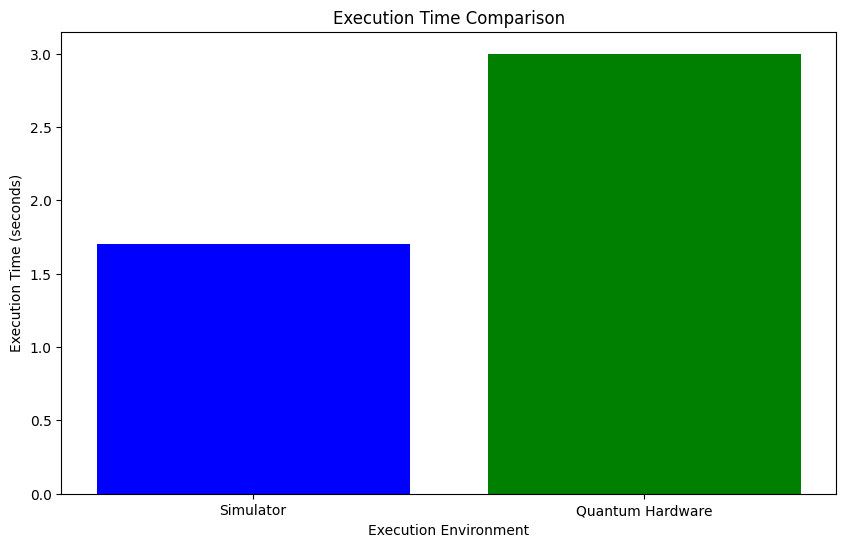

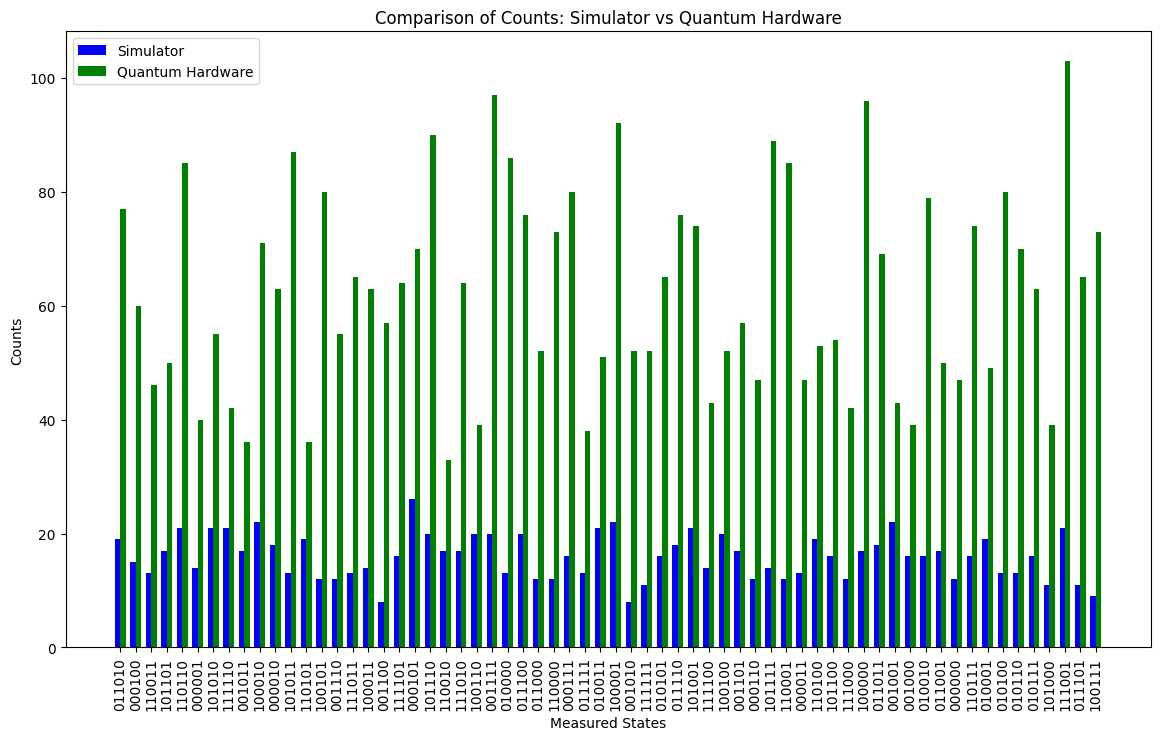

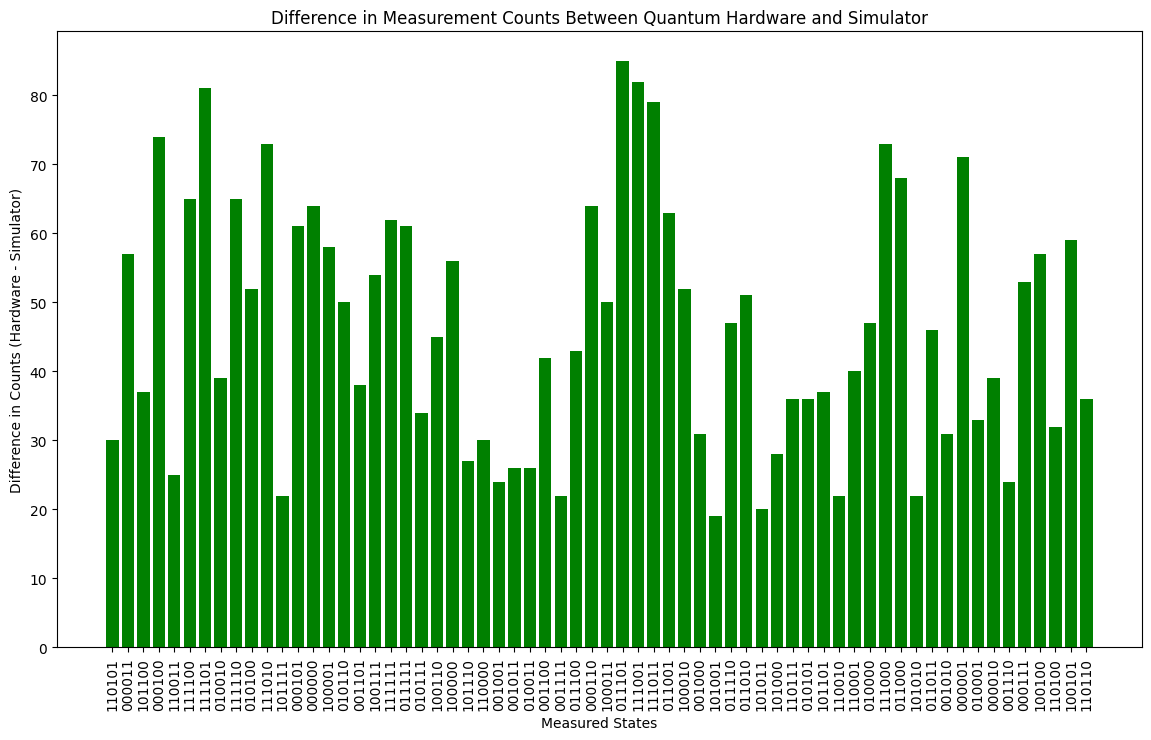

In [48]:
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
import numpy as np

# Sample data (replace with actual counts and times from the execution)
simulator_time = 1.7  # Replace with actual time
hardware_time = 3.0  # Replace with actual time
counts_simulator = {'011010': 19, '000100': 15, '110011': 13, '101101': 17, '110110': 21, '000001': 14, '101010': 21, '111110': 21, '001011': 17, '100010': 22, '000010': 18, '101011': 13, '110101': 19, '100101': 12, '001110': 12, '111011': 13, '100011': 14, '001100': 8, '111101': 16, '000101': 26, '101110': 20, '110010': 17, '111010': 17, '100110': 20, '001111': 20, '010000': 13, '011100': 20, '011000': 12, '110000': 12, '000111': 16, '011111': 13, '010011': 21, '100001': 22, '001010': 8, '111111': 11, '010101': 16, '011110': 18, '101001': 21, '111100': 14, '100100': 20, '001101': 17, '000110': 12, '101111': 14, '110001': 12, '000011': 13, '110100': 19, '101100': 16, '111000': 12, '100000': 17, '011011': 18, '001001': 22, '001000': 16, '010010': 16, '011001': 17, '000000': 12, '110111': 16, '010001': 19, '010100': 13, '010110': 13, '010111': 16, '101000': 11, '111001': 21, '011101': 11, '100111': 9}
counts_hardware = {'100100': 77, '010000': 60, '001001': 46, '001100': 50, '111000': 85, '101001': 40, '001101': 55, '001111': 42, '001110': 36, '100101': 71, '010110': 63, '000101': 87, '101111': 36, '100001': 80, '010010': 55, '010100': 65, '011100': 63, '110110': 57, '011011': 64, '000011': 70, '111010': 90, '101011': 33, '100011': 64, '101000': 39, '111101': 97, '111110': 86, '000110': 76, '010001': 52, '111111': 73, '011000': 80, '110011': 38, '110100': 51, '111011': 92, '110001': 52, '110111': 52, '011110': 65, '000000': 76, '100010': 74, '101010': 43, '010101': 52, '000010': 57, '101110': 47, '000100': 89, '000001': 85, '010011': 47, '101100': 53, '101101': 54, '110000': 42, '011101': 96, '000111': 69, '001011': 43, '001010': 39, '111100': 79, '010111': 50, '001000': 47, '011111': 74, '110101': 49, '011001': 80, '011010': 70, '100111': 63, '110010': 39, '111001': 103, '100110': 65, '100000': 73}

# Time comparison
plt.figure(figsize=(10, 6))
times = [simulator_time, hardware_time]
labels = ['Simulator', 'Quantum Hardware']
plt.bar(labels, times, color=['blue', 'green'])
plt.xlabel('Execution Environment')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time Comparison')
plt.show()

# Results comparison with different colors for simulator and hardware
plt.figure(figsize=(14, 8))
bar_width = 0.35
index = np.arange(len(counts_simulator))
simulator_bar = plt.bar(index, counts_simulator.values(), bar_width, color='blue', label='Simulator')
hardware_bar = plt.bar(index + bar_width, counts_hardware.values(), bar_width, color='green', label='Quantum Hardware')

plt.xlabel('Measured States')
plt.ylabel('Counts')
plt.title('Comparison of Counts: Simulator vs Quantum Hardware')
plt.xticks(index + bar_width / 2, counts_simulator.keys(), rotation=90)
plt.legend()
plt.show()

# Statistical comparison: Difference between counts
all_keys = set(counts_simulator.keys()).union(set(counts_hardware.keys()))
differences = {key: counts_hardware.get(key, 0) - counts_simulator.get(key, 0) for key in all_keys}

# Plot the difference in counts
plt.figure(figsize=(14, 8))
colors = ['red' if differences[key] < 0 else 'green' for key in differences]
plt.bar(differences.keys(), differences.values(), color=colors)
plt.xlabel('Measured States')
plt.ylabel('Difference in Counts (Hardware - Simulator)')
plt.title('Difference in Measurement Counts Between Quantum Hardware and Simulator')
plt.xticks(rotation=90)
plt.show()


# 2nd Iteration 

## Simulator 

In [52]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np

# Function to perform polynomial multiplication (optimized for fewer qubits)
def polynomial_multiplication(qc, a, b, result):
    for i in range(len(a)):
        for j in range(len(b)):
            if i + j < len(result):
                qc.cx(a[i], result[i + j])

# Function to perform modular reduction
def modular_reduction(qc, poly, mod):
    for i in range(len(poly) - len(mod) + 1):
        if poly[i] == 1:
            for j in range(len(mod)):
                qc.cx(poly[i + j], mod[j])

# Function to perform multiplicative inverse in polynomial ring
def multiplicative_inverse(qc, poly):
    for q in poly:
        qc.h(q)
    for i in range(len(poly) - 1):
        qc.cx(poly[i], poly[i + 1])
    if len(poly) >= 3:
        qc.ccx(poly[0], poly[1], poly[2])

# Implement AES S-box
def aes_sbox(qc, qubits):
    multiplicative_inverse(qc, qubits)
    affine_transformation(qc, qubits)

def affine_transformation(qc, qubits):
    affine_matrix = [
        [1, 1, 0, 1, 0, 1],
        [0, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 0],
        [0, 1, 1, 0, 0, 1],
        [1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1]
    ]
    constant = [1, 0, 1, 0, 1, 0]
    
    for i, row in enumerate(affine_matrix):
        for j, bit in enumerate(row):
            if bit and i != j and j < len(qubits) and i < len(qubits):
                qc.cx(qubits[j], qubits[i])
        if constant[i] and i < len(qubits):
            qc.x(qubits[i])

# Function to perform NTRU encryption
def ntru_encrypt(qc, message, key, result):
    polynomial_multiplication(qc, message, key, result)
    mod_poly = [1] * len(result)  # This should be the modulus polynomial for reduction
    modular_reduction(qc, result, mod_poly)

# Quantum Error Correction using repetition code
def apply_qec(qc, qubits):
    ancillas = QuantumRegister(len(qubits), 'ancilla')
    qc.add_register(ancillas)
    for i, q in enumerate(qubits):
        qc.cx(q, ancillas[i])
        qc.cx(q, ancillas[(i + 1) % len(qubits)])
    return ancillas

# Function to create a normalized state vector
def create_normalized_state(size):
    norm_factor = np.sqrt(size)
    return [1/norm_factor] * size

# Simulating the circuit
def simulate_circuit():
    num_qubits = 6  # Reduced number of qubits for AES S-box
    qc = QuantumCircuit(num_qubits)

    # Apply the AES S-box
    aes_sbox(qc, range(num_qubits))

    # Apply NTRU encryption
    message = create_normalized_state(2**num_qubits)  # Valid normalized state vector for the message
    key = create_normalized_state(2**num_qubits)  # Valid normalized state vector for the key
    message_qubits = QuantumRegister(num_qubits, 'msg')
    key_qubits = QuantumRegister(num_qubits, 'key')
    result_qubits = QuantumRegister(num_qubits, 'result')
    qc.add_register(message_qubits)
    qc.add_register(key_qubits)
    qc.add_register(result_qubits)
    qc.initialize(message, message_qubits)
    qc.initialize(key, key_qubits)
    ntru_encrypt(qc, message_qubits, key_qubits, result_qubits)

    # Apply quantum error correction
    ancillas = apply_qec(qc, range(num_qubits))

    # Measure the qubits
    cr = ClassicalRegister(num_qubits)
    qc.add_register(cr)
    qc.measure(range(num_qubits), cr)

    # Visualize the circuit
    qc.draw('mpl')

    # Execute the circuit on the simulator
    simulator = AerSimulator()
    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit).result()
    counts_simulator = result.get_counts()
    plot_histogram(counts_simulator).show()

    return counts_simulator

# Run the simulation
counts_simulator = simulate_circuit()
print(counts_simulator)

{'101000': 13, '001111': 16, '111010': 20, '100110': 15, '010100': 17, '101110': 17, '000101': 14, '110010': 19, '110110': 19, '101010': 21, '000001': 12, '111101': 13, '001100': 16, '100011': 18, '100010': 17, '001011': 13, '111110': 15, '010011': 14, '011101': 15, '100101': 16, '111011': 15, '001110': 20, '100100': 17, '001101': 21, '111100': 25, '111001': 17, '010110': 15, '100111': 30, '011011': 19, '001010': 11, '100001': 13, '111111': 18, '110100': 20, '101100': 11, '000011': 20, '000000': 11, '110111': 20, '110101': 17, '101011': 10, '000010': 17, '101001': 20, '010111': 26, '101101': 15, '000100': 16, '110011': 21, '001000': 13, '010000': 14, '011010': 18, '000110': 6, '110001': 12, '101111': 11, '010101': 19, '011110': 15, '011111': 19, '010010': 11, '100000': 16, '011001': 18, '001001': 10, '000111': 14, '110000': 13, '010001': 8, '011100': 10, '011000': 14, '111000': 18}


C:\Users\muham\AppData\Local\Temp\ipykernel_15604\1716933916.py:109: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_histogram(counts_simulator).show()


## Hardware 

In [62]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram
import numpy as np

# Function to perform polynomial multiplication (optimized for fewer qubits)
def polynomial_multiplication(qc, a, b, result):
    for i in range(len(a)):
        for j in range(len(b)):
            if i + j < len(result):
                qc.cx(a[i], result[i + j])

# Function to perform modular reduction
def modular_reduction(qc, poly, mod):
    for i in range(len(poly) - len(mod) + 1):
        if poly[i] == 1:
            for j in range(len(mod)):
                qc.cx(poly[i + j], mod[j])

# Function to perform multiplicative inverse in polynomial ring
def multiplicative_inverse(qc, poly):
    for q in poly:
        qc.h(q)
    for i in range(len(poly) - 1):
        qc.cx(poly[i], poly[i + 1])
    if len(poly) >= 3:
        qc.ccx(poly[0], poly[1], poly[2])

# Implement AES S-box
def aes_sbox(qc, qubits):
    multiplicative_inverse(qc, qubits)
    affine_transformation(qc, qubits)

def affine_transformation(qc, qubits):
    affine_matrix = [
        [1, 1, 0, 1, 0, 1],
        [0, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 0],
        [0, 1, 1, 0, 0, 1],
        [1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1]
    ]
    constant = [1, 0, 1, 0, 1, 0]
    
    for i, row in enumerate(affine_matrix):
        for j, bit in enumerate(row):
            if bit and i != j and j < len(qubits) and i < len(qubits):
                qc.cx(qubits[j], qubits[i])
        if constant[i] and i < len(qubits):
            qc.x(qubits[i])

# Function to perform NTRU encryption
def ntru_encrypt(qc, message, key, result):
    polynomial_multiplication(qc, message, key, result)
    mod_poly = [1] * len(result)  # This should be the modulus polynomial for reduction
    modular_reduction(qc, result, mod_poly)

# Quantum Error Correction using repetition code
def apply_qec(qc, qubits):
    ancillas = QuantumRegister(len(qubits), 'ancilla')
    qc.add_register(ancillas)
    for i, q in enumerate(qubits):
        qc.cx(q, ancillas[i])
        qc.cx(q, ancillas[(i + 1) % len(qubits)])
    return ancillas

# Function to create a normalized state vector
def create_normalized_state(size):
    norm_factor = np.sqrt(size)
    return [1/norm_factor] * size

# Executing on quantum hardware
def run_on_hardware():
    num_qubits = 6  # Reduced number of qubits for AES S-box
    qc = QuantumCircuit(num_qubits)

    # Apply the AES S-box
    aes_sbox(qc, range(num_qubits))

    # Apply NTRU encryption
    message = create_normalized_state(2**num_qubits)  # Valid normalized state vector for the message
    key = create_normalized_state(2**num_qubits)  # Valid normalized state vector for the key
    message_qubits = QuantumRegister(num_qubits, 'msg')
    key_qubits = QuantumRegister(num_qubits, 'key')
    result_qubits = QuantumRegister(num_qubits, 'result')
    qc.add_register(message_qubits)
    qc.add_register(key_qubits)
    qc.add_register(result_qubits)
    qc.initialize(message, message_qubits)
    qc.initialize(key, key_qubits)
    ntru_encrypt(qc, message_qubits, key_qubits, result_qubits)

    # Apply quantum error correction
    ancillas = apply_qec(qc, range(num_qubits))

    # Measure the qubits
    cr = ClassicalRegister(num_qubits)
    qc.add_register(cr)
    qc.measure(range(num_qubits), cr)

    # Authenticate to IBM Quantum using QiskitRuntimeService
    service = QiskitRuntimeService(channel="ibm_quantum", token="9b1db8ecdf455c71e9d97b2ba4c8e3cc6dbfcc1e2ffc3b92fd5c5c5777f92796798d6ef2bdc53aebc6da1fe7b205a6dc35114382f3172a9d167469d824539767")

    # Get the backend
    backend = service.backend("ibm_kyoto")

    # Execute the circuit on the quantum hardware
    compiled_circuit = transpile(qc, backend)
    job = backend.run(compiled_circuit)
    result = job.result()
    counts_hardware = result.get_counts()
    plot_histogram(counts_hardware).show()

    return counts_hardware

# Run on quantum hardware
counts_hardware = run_on_hardware()


C:\Users\muham\AppData\Local\Temp\ipykernel_15604\1480811003.py:109: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  job = backend.run(compiled_circuit)
C:\Users\muham\AppData\Local\Temp\ipykernel_15604\1480811003.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_histogram(counts_hardware).show()


In [70]:
get_the_job("cttpvky66x8g008q24y0")

{'110001': 41, '011100': 77, '101010': 44, '000110': 56, '100010': 52, '100110': 76, '101111': 69, '001001': 38, '111111': 101, '010100': 81, '110010': 64, '100100': 86, '110110': 84, '101000': 60, '111110': 100, '001010': 50, '000010': 50, '110101': 70, '001011': 43, '001101': 58, '101011': 38, '111001': 56, '101100': 73, '100001': 41, '101101': 64, '011110': 98, '011111': 67, '110011': 67, '110111': 68, '010001': 53, '010010': 56, '010011': 37, '111100': 111, '000111': 68, '000001': 47, '010110': 89, '001100': 77, '011000': 69, '111101': 73, '000000': 41, '001110': 75, '111010': 59, '110100': 84, '101001': 50, '010101': 77, '110000': 51, '101110': 68, '000100': 62, '111011': 52, '001000': 52, '010000': 40, '011010': 61, '100000': 50, '001111': 59, '100101': 49, '010111': 76, '100011': 46, '011011': 56, '100111': 45, '000011': 37, '011101': 68, '011001': 69, '000101': 58, '111000': 63}


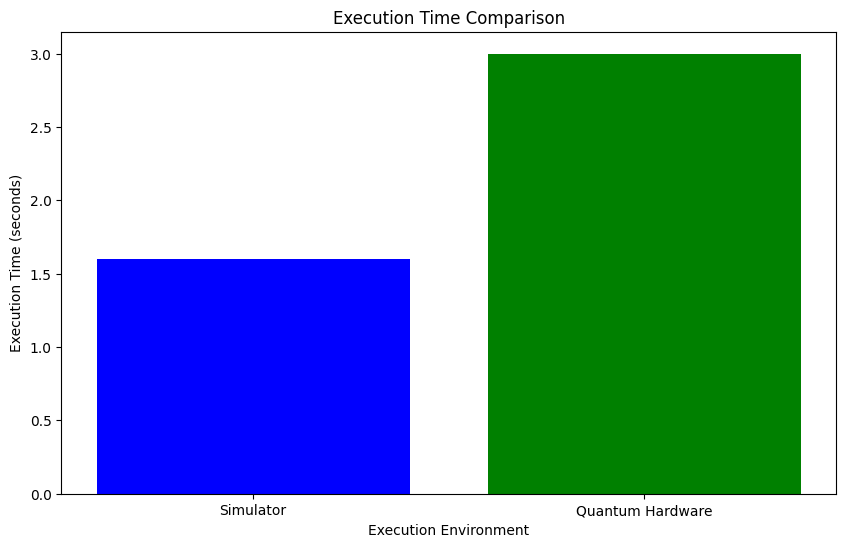

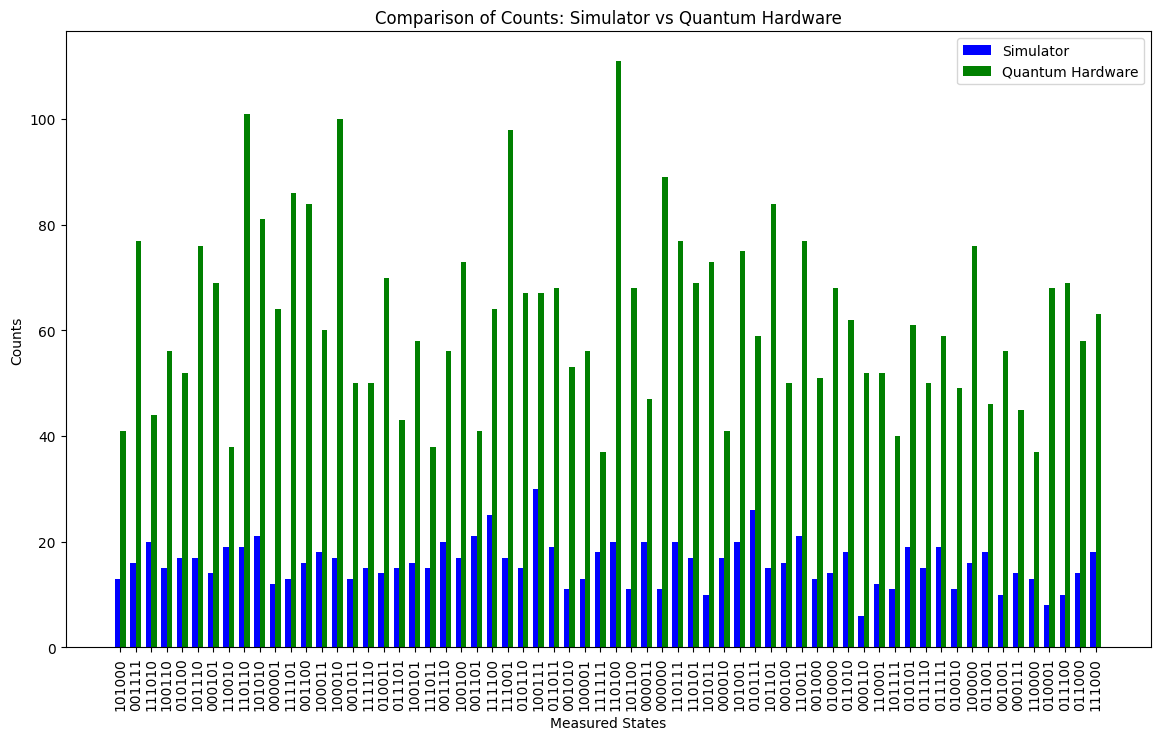

In [74]:
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
import numpy as np

# Sample data (replace with actual counts and times from the execution)
simulator_time = 1.6  # Replace with actual time
hardware_time = 3.0  # Replace with actual time
counts_simulator = {'101000': 13, '001111': 16, '111010': 20, '100110': 15, '010100': 17, '101110': 17, '000101': 14, '110010': 19, '110110': 19, '101010': 21, '000001': 12, '111101': 13, '001100': 16, '100011': 18, '100010': 17, '001011': 13, '111110': 15, '010011': 14, '011101': 15, '100101': 16, '111011': 15, '001110': 20, '100100': 17, '001101': 21, '111100': 25, '111001': 17, '010110': 15, '100111': 30, '011011': 19, '001010': 11, '100001': 13, '111111': 18, '110100': 20, '101100': 11, '000011': 20, '000000': 11, '110111': 20, '110101': 17, '101011': 10, '000010': 17, '101001': 20, '010111': 26, '101101': 15, '000100': 16, '110011': 21, '001000': 13, '010000': 14, '011010': 18, '000110': 6, '110001': 12, '101111': 11, '010101': 19, '011110': 15, '011111': 19, '010010': 11, '100000': 16, '011001': 18, '001001': 10, '000111': 14, '110000': 13, '010001': 8, '011100': 10, '011000': 14, '111000': 18}

counts_hardware = {'110001': 41, '011100': 77, '101010': 44, '000110': 56, '100010': 52, '100110': 76, '101111': 69, '001001': 38, '111111': 101, '010100': 81, '110010': 64, '100100': 86, '110110': 84, '101000': 60, '111110': 100, '001010': 50, '000010': 50, '110101': 70, '001011': 43, '001101': 58, '101011': 38, '111001': 56, '101100': 73, '100001': 41, '101101': 64, '011110': 98, '011111': 67, '110011': 67, '110111': 68, '010001': 53, '010010': 56, '010011': 37, '111100': 111, '000111': 68, '000001': 47, '010110': 89, '001100': 77, '011000': 69, '111101': 73, '000000': 41, '001110': 75, '111010': 59, '110100': 84, '101001': 50, '010101': 77, '110000': 51, '101110': 68, '000100': 62, '111011': 52, '001000': 52, '010000': 40, '011010': 61, '100000': 50, '001111': 59, '100101': 49, '010111': 76, '100011': 46, '011011': 56, '100111': 45, '000011': 37, '011101': 68, '011001': 69, '000101': 58, '111000': 63}

# Time comparison
plt.figure(figsize=(10, 6))
times = [simulator_time, hardware_time]
labels = ['Simulator', 'Quantum Hardware']
plt.bar(labels, times, color=['blue', 'green'])
plt.xlabel('Execution Environment')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time Comparison')
plt.show()

# Results comparison with different colors for simulator and hardware
plt.figure(figsize=(14, 8))
bar_width = 0.35
index = np.arange(len(counts_simulator))
simulator_bar = plt.bar(index, counts_simulator.values(), bar_width, color='blue', label='Simulator')
hardware_bar = plt.bar(index + bar_width, counts_hardware.values(), bar_width, color='green', label='Quantum Hardware')

plt.xlabel('Measured States')
plt.ylabel('Counts')
plt.title('Comparison of Counts: Simulator vs Quantum Hardware')
plt.xticks(index + bar_width / 2, counts_simulator.keys(), rotation=90)
plt.legend()
plt.show()

# # Statistical comparison: Difference between counts
# all_keys = set(counts_simulator.keys()).union(set(counts_hardware.keys()))
# differences = {key: counts_hardware.get(key, 0) - counts_simulator.get(key, 0) for key in all_keys}

# Plot the difference in counts
# plt.figure(figsize=(14, 8))
# colors = ['red' if differences[key] < 0 else 'green' for key in differences]
# plt.bar(differences.keys(), differences.values(), color=colors)
# plt.xlabel('Measured States')
# plt.ylabel('Difference in Counts (Hardware - Simulator)')
# plt.title('Difference in Measurement Counts Between Quantum Hardware and Simulator')
# plt.xticks(rotation=90)
# plt.show()


# 3rd Iteration

In [4]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import AerSimulator, noise

In [13]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np

# Function to perform polynomial multiplication (optimized for fewer qubits)
def polynomial_multiplication(qc, a, b, result):
    for i in range(len(a)):
        for j in range(len(b)):
            if i + j < len(result):
                qc.cx(a[i], result[i + j])

# Function to perform modular reduction
def modular_reduction(qc, poly, mod):
    for i in range(len(poly) - len(mod) + 1):
        if poly[i] == 1:
            for j in range(len(mod)):
                qc.cx(poly[i + j], mod[j])

# Function to perform multiplicative inverse in polynomial ring
def multiplicative_inverse(qc, poly):
    for q in poly:
        qc.h(q)
    for i in range(len(poly) - 1):
        qc.cx(poly[i], poly[i + 1])
    if len(poly) >= 3:
        qc.ccx(poly[0], poly[1], poly[2])

# Implement AES S-box
def aes_sbox(qc, qubits):
    multiplicative_inverse(qc, qubits)
    affine_transformation(qc, qubits)

def affine_transformation(qc, qubits):
    affine_matrix = [
        [1, 1, 0, 1, 0, 1],
        [0, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 0],
        [0, 1, 1, 0, 0, 1],
        [1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1]
    ]
    constant = [1, 0, 1, 0, 1, 0]
    
    for i, row in enumerate(affine_matrix):
        for j, bit in enumerate(row):
            if bit and i != j and j < len(qubits) and i < len(qubits):
                qc.cx(qubits[j], qubits[i])
        if constant[i] and i < len(qubits):
            qc.x(qubits[i])

# Function to perform NTRU encryption
def ntru_encrypt(qc, message, key, result):
    polynomial_multiplication(qc, message, key, result)
    mod_poly = [1] * len(result)  # This should be the modulus polynomial for reduction
    modular_reduction(qc, result, mod_poly)

# Quantum Error Correction using repetition code
def apply_qec(qc, qubits):
    ancillas = QuantumRegister(len(qubits), 'ancilla')
    qc.add_register(ancillas)
    for i, q in enumerate(qubits):
        qc.cx(q, ancillas[i])
        qc.cx(q, ancillas[(i + 1) % len(qubits)])
    return ancillas

# Function to create a normalized state vector
def create_normalized_state(size):
    norm_factor = np.sqrt(size)
    return [1/norm_factor] * size

# Simulating the circuit
def simulate_circuit():
    num_qubits = 6  # Reduced number of qubits for AES S-box
    qc = QuantumCircuit(num_qubits)

    # Apply the AES S-box
    aes_sbox(qc, range(num_qubits))

    # Apply NTRU encryption
    message = create_normalized_state(2**num_qubits)  # Valid normalized state vector for the message
    key = create_normalized_state(2**num_qubits)  # Valid normalized state vector for the key
    message_qubits = QuantumRegister(num_qubits, 'msg')
    key_qubits = QuantumRegister(num_qubits, 'key')
    result_qubits = QuantumRegister(num_qubits, 'result')
    qc.add_register(message_qubits)
    qc.add_register(key_qubits)
    qc.add_register(result_qubits)
    qc.initialize(message, message_qubits)
    qc.initialize(key, key_qubits)
    ntru_encrypt(qc, message_qubits, key_qubits, result_qubits)

    # Apply quantum error correction
    ancillas = apply_qec(qc, range(num_qubits))

    # Measure the qubits
    cr = ClassicalRegister(num_qubits)
    qc.add_register(cr)
    qc.measure(range(num_qubits), cr)

    # Visualize the circuit
    qc.draw('mpl')

    # Execute the circuit on the simulator
    simulator = AerSimulator()
    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit).result()
    counts_simulator = result.get_counts()
    plot_histogram(counts_simulator).show()

    return counts_simulator

# Run the simulation
counts_simulator = simulate_circuit()
print(counts_simulator)


{'001111': 13, '100110': 16, '111010': 10, '000110': 12, '110001': 12, '101111': 19, '111110': 15, '001011': 19, '100010': 14, '010011': 19, '000101': 17, '110010': 18, '101110': 15, '010100': 28, '100111': 13, '010010': 23, '010110': 11, '001101': 7, '100100': 16, '111100': 19, '000001': 10, '101010': 11, '110110': 26, '001001': 17, '000011': 12, '110100': 22, '101100': 19, '110111': 11, '000000': 16, '011010': 14, '010111': 15, '101001': 18, '111101': 16, '001100': 23, '100011': 13, '100000': 20, '111111': 12, '001010': 13, '100001': 13, '011110': 15, '011000': 20, '011001': 21, '011101': 16, '110000': 23, '000111': 12, '010000': 21, '101011': 13, '000010': 12, '110101': 16, '101000': 20, '010001': 19, '011111': 14, '100101': 22, '001110': 14, '111011': 16, '011100': 18, '010101': 22, '111000': 17, '001000': 15, '011011': 7, '101101': 12, '110011': 13, '000100': 14, '111001': 15}


C:\Users\muham\AppData\Local\Temp\ipykernel_11724\3571978131.py:109: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_histogram(counts_simulator).show()


## hardware 

In [16]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram
import numpy as np

# Same functions as in the simulator section
# (include polynomial_multiplication, modular_reduction, multiplicative_inverse, aes_sbox, affine_transformation, ntru_encrypt, apply_qec, create_normalized_state)

# Running on quantum hardware
def run_on_hardware():
    num_qubits = 6
    qc = QuantumCircuit(num_qubits)

    # Apply the AES S-box
    aes_sbox(qc, range(num_qubits))

    # Apply NTRU encryption
    message = create_normalized_state(2**num_qubits)
    key = create_normalized_state(2**num_qubits)
    message_qubits = QuantumRegister(num_qubits, 'msg')
    key_qubits = QuantumRegister(num_qubits, 'key')
    result_qubits = QuantumRegister(num_qubits, 'result')
    qc.add_register(message_qubits)
    qc.add_register(key_qubits)
    qc.add_register(result_qubits)
    qc.initialize(message, message_qubits)
    qc.initialize(key, key_qubits)
    ntru_encrypt(qc, message_qubits, key_qubits, result_qubits)

    # Apply quantum error correction
    ancillas = apply_qec(qc, range(num_qubits))

    # Measure the qubits
    cr = ClassicalRegister(num_qubits)
    qc.add_register(cr)
    qc.measure(range(num_qubits), cr)

    # Authenticate to IBM Quantum using QiskitRuntimeService
    service = QiskitRuntimeService(channel="ibm_quantum", token=API_KEY)

    # Get the backend
    backend = service.backend("ibm_kyoto")

    # Execute the circuit on the quantum hardware
    compiled_circuit = transpile(qc, backend)
    job = backend.run(compiled_circuit)
    result = job.result()
    counts_hardware = result.get_counts()

    plot_histogram(counts_hardware).show()

    return counts_hardware

# Run on quantum hardware
counts_hardware = run_on_hardware()
print(counts_hardware)


C:\Users\muham\AppData\Local\Temp\ipykernel_11724\735087006.py:46: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  job = backend.run(compiled_circuit)


{'000111': 59, '111000': 69, '000110': 42, '011100': 78, '000001': 66, '001101': 61, '010101': 73, '101011': 84, '010011': 58, '110100': 60, '111010': 59, '101110': 45, '111101': 82, '010010': 77, '011110': 54, '011011': 78, '101100': 69, '000011': 73, '110011': 80, '011001': 64, '010110': 45, '101101': 66, '011111': 63, '111011': 62, '010100': 61, '111100': 62, '110110': 53, '001000': 77, '000101': 77, '001010': 63, '111001': 52, '101000': 64, '100010': 65, '011101': 65, '110001': 60, '100000': 61, '100111': 56, '001001': 52, '010000': 64, '001111': 45, '100101': 75, '100110': 49, '010111': 41, '001011': 61, '101010': 71, '000010': 74, '001110': 41, '110010': 52, '001100': 57, '101111': 46, '100001': 70, '111110': 43, '011010': 76, '000100': 63, '000000': 64, '011000': 60, '100011': 62, '101001': 80, '111111': 47, '010001': 80, '110101': 83, '110000': 56, '110111': 48, '100100': 57}


C:\Users\muham\AppData\Local\Temp\ipykernel_11724\735087006.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_histogram(counts_hardware).show()


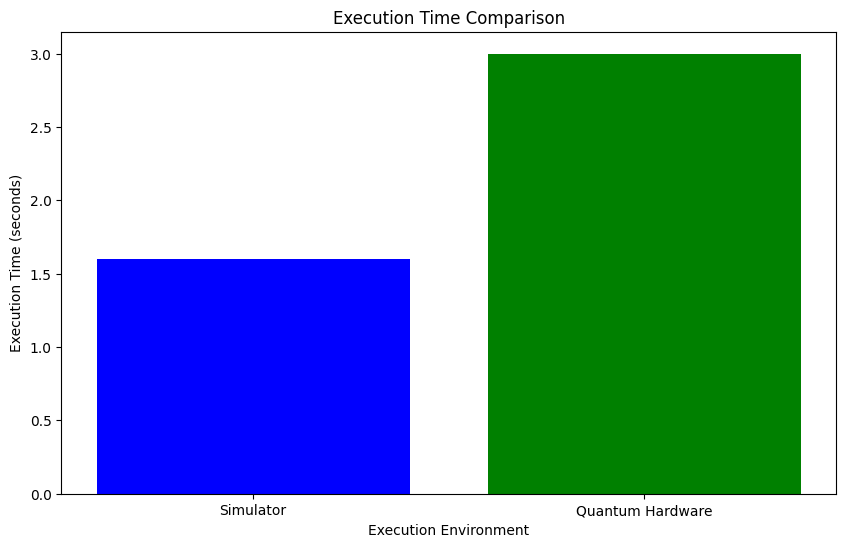

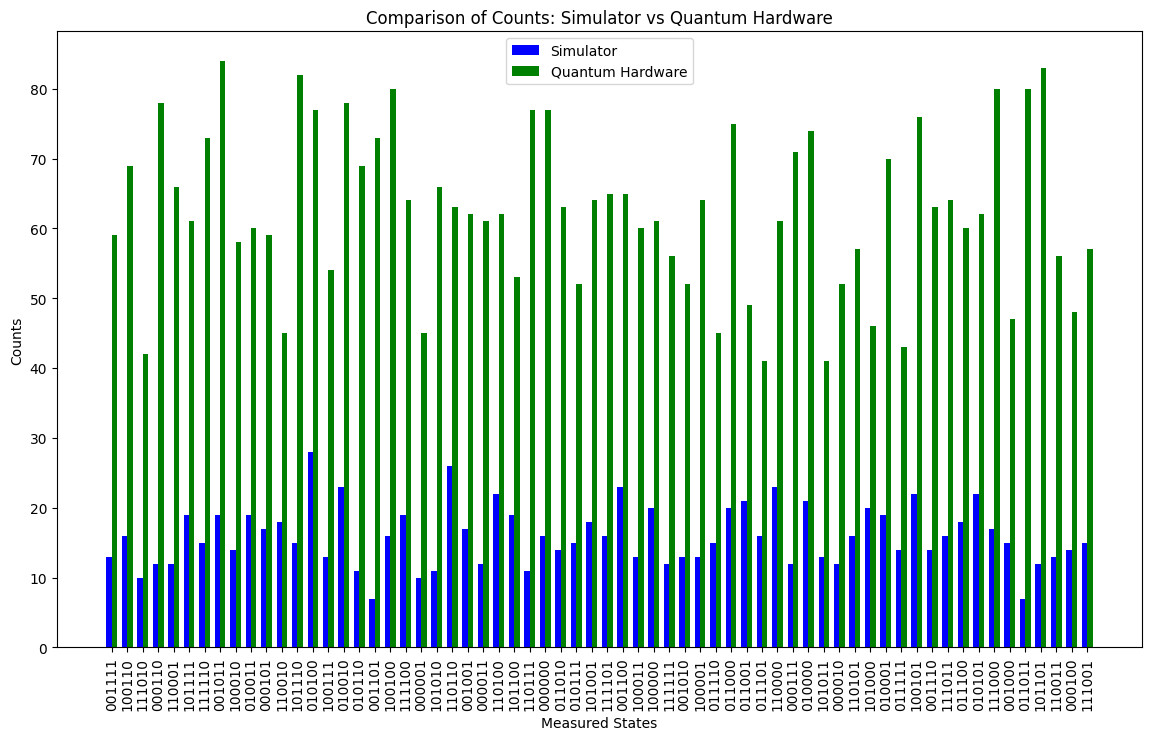

In [17]:
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
import numpy as np

# Sample data (replace with actual counts and times from the execution)
simulator_time = 1.6  # Replace with actual time
hardware_time = 3.0  # Replace with actual time
counts_simulator = {'001111': 13, '100110': 16, '111010': 10, '000110': 12, '110001': 12, '101111': 19, '111110': 15, '001011': 19, '100010': 14, '010011': 19, '000101': 17, '110010': 18, '101110': 15, '010100': 28, '100111': 13, '010010': 23, '010110': 11, '001101': 7, '100100': 16, '111100': 19, '000001': 10, '101010': 11, '110110': 26, '001001': 17, '000011': 12, '110100': 22, '101100': 19, '110111': 11, '000000': 16, '011010': 14, '010111': 15, '101001': 18, '111101': 16, '001100': 23, '100011': 13, '100000': 20, '111111': 12, '001010': 13, '100001': 13, '011110': 15, '011000': 20, '011001': 21, '011101': 16, '110000': 23, '000111': 12, '010000': 21, '101011': 13, '000010': 12, '110101': 16, '101000': 20, '010001': 19, '011111': 14, '100101': 22, '001110': 14, '111011': 16, '011100': 18, '010101': 22, '111000': 17, '001000': 15, '011011': 7, '101101': 12, '110011': 13, '000100': 14, '111001': 15}
counts_hardware = {'000111': 59, '111000': 69, '000110': 42, '011100': 78, '000001': 66, '001101': 61, '010101': 73, '101011': 84, '010011': 58, '110100': 60, '111010': 59, '101110': 45, '111101': 82, '010010': 77, '011110': 54, '011011': 78, '101100': 69, '000011': 73, '110011': 80, '011001': 64, '010110': 45, '101101': 66, '011111': 63, '111011': 62, '010100': 61, '111100': 62, '110110': 53, '001000': 77, '000101': 77, '001010': 63, '111001': 52, '101000': 64, '100010': 65, '011101': 65, '110001': 60, '100000': 61, '100111': 56, '001001': 52, '010000': 64, '001111': 45, '100101': 75, '100110': 49, '010111': 41, '001011': 61, '101010': 71, '000010': 74, '001110': 41, '110010': 52, '001100': 57, '101111': 46, '100001': 70, '111110': 43, '011010': 76, '000100': 63, '000000': 64, '011000': 60, '100011': 62, '101001': 80, '111111': 47, '010001': 80, '110101': 83, '110000': 56, '110111': 48, '100100': 57}
# Time comparison
plt.figure(figsize=(10, 6))
times = [simulator_time, hardware_time]
labels = ['Simulator', 'Quantum Hardware']
plt.bar(labels, times, color=['blue', 'green'])
plt.xlabel('Execution Environment')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time Comparison')
plt.show()

# Results comparison with different colors for simulator and hardware
plt.figure(figsize=(14, 8))
bar_width = 0.35
index = np.arange(len(counts_simulator))
simulator_bar = plt.bar(index, counts_simulator.values(), bar_width, color='blue', label='Simulator')
hardware_bar = plt.bar(index + bar_width, counts_hardware.values(), bar_width, color='green', label='Quantum Hardware')

plt.xlabel('Measured States')
plt.ylabel('Counts')
plt.title('Comparison of Counts: Simulator vs Quantum Hardware')
plt.xticks(index + bar_width / 2, counts_simulator.keys(), rotation=90)
plt.legend()
plt.show()

# # Statistical comparison: Difference between counts
# all_keys = set(counts_simulator.keys()).union(set(counts_hardware.keys()))
# differences = {key: counts_hardware.get(key, 0) - counts_simulator.get(key, 0) for key in all_keys}

# Plot the difference in counts
# plt.figure(figsize=(14, 8))
# colors = ['red' if differences[key] < 0 else 'green' for key in differences]
# plt.bar(differences.keys(), differences.values(), color=colors)
# plt.xlabel('Measured States')
# plt.ylabel('Difference in Counts (Hardware - Simulator)')
# plt.title('Difference in Measurement Counts Between Quantum Hardware and Simulator')
# plt.xticks(rotation=90)
# plt.show()


In [18]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import AerSimulator, noise
from qiskit.visualization import plot_histogram
import numpy as np
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError

In [19]:


# Function to perform polynomial multiplication (optimized for fewer qubits)
def polynomial_multiplication(qc, a, b, result):
    for i in range(len(a)):
        for j in range(len(b)):
            if i + j < len(result):
                qc.cx(a[i], result[i + j])

# Function to perform modular reduction
def modular_reduction(qc, poly, mod):
    for i in range(len(poly) - len(mod) + 1):
        if poly[i] == 1:
            for j in range(len(mod)):
                qc.cx(poly[i + j], mod[j])

# Function to perform multiplicative inverse in polynomial ring
def multiplicative_inverse(qc, poly):
    for q in poly:
        qc.h(q)
    for i in range(len(poly) - 1):
        qc.cx(poly[i], poly[i + 1])
    if len(poly) >= 3:
        qc.ccx(poly[0], poly[1], poly[2])

# Implement AES S-box
def aes_sbox(qc, qubits):
    multiplicative_inverse(qc, qubits)
    affine_transformation(qc, qubits)

def affine_transformation(qc, qubits):
    affine_matrix = [
        [1, 1, 0, 1, 0, 1],
        [0, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 0],
        [0, 1, 1, 0, 0, 1],
        [1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1]
    ]
    constant = [1, 0, 1, 0, 1, 0]
    
    for i, row in enumerate(affine_matrix):
        for j, bit in enumerate(row):
            if bit and i != j and j < len(qubits) and i < len(qubits):
                qc.cx(qubits[j], qubits[i])
        if constant[i] and i < len(qubits):
            qc.x(qubits[i])

# Function to perform NTRU encryption
def ntru_encrypt(qc, message, key, result):
    polynomial_multiplication(qc, message, key, result)
    mod_poly = [1] * len(result)  # This should be the modulus polynomial for reduction
    modular_reduction(qc, result, mod_poly)

# Quantum Error Correction using repetition code
def apply_qec(qc, qubits):
    ancillas = QuantumRegister(len(qubits), 'ancilla')
    qc.add_register(ancillas)
    for i, q in enumerate(qubits):
        qc.cx(q, ancillas[i])
        qc.cx(q, ancillas[(i + 1) % len(qubits)])
    return ancillas

# Function to create a normalized state vector
def create_normalized_state(size):
    norm_factor = np.sqrt(size)
    return [1/norm_factor] * size

# Create a custom noise model to reduce noise
def create_noise_model():
    noise_model = NoiseModel()

    # Depolarizing error for single qubit gates
    depol_error = depolarizing_error(0.01, 1)
    noise_model.add_all_qubit_quantum_error(depol_error, ['u1', 'u2', 'u3'])

    # Depolarizing error for two-qubit gates (like CNOT)
    depol_error_cx = depolarizing_error(0.02, 2)
    noise_model.add_all_qubit_quantum_error(depol_error_cx, ['cx'])

    # Thermal relaxation errors
    T1 = 50e3  # us
    T2 = 70e3  # us
    time_u3 = 100  # ns
    time_cx = 300  # ns

    thermal_error = thermal_relaxation_error(T1, T2, time_u3)
    thermal_error_cx = thermal_relaxation_error(T1, T2, time_cx).expand(thermal_relaxation_error(T1, T2, time_cx))

    noise_model.add_all_qubit_quantum_error(thermal_error, ['u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(thermal_error_cx, ['cx'])

    # Readout errors
    readout_error = ReadoutError([[0.95, 0.05], [0.1, 0.9]])
    noise_model.add_all_qubit_readout_error(readout_error)

    return noise_model

# Simulating the circuit with noise
def simulate_circuit_with_noise():
    num_qubits = 6  # Reduced number of qubits for AES S-box
    qc = QuantumCircuit(num_qubits)

    # Apply the AES S-box
    aes_sbox(qc, range(num_qubits))

    # Apply NTRU encryption
    message = create_normalized_state(2**num_qubits)  # Valid normalized state vector for the message
    key = create_normalized_state(2**num_qubits)  # Valid normalized state vector for the key
    message_qubits = QuantumRegister(num_qubits, 'msg')
    key_qubits = QuantumRegister(num_qubits, 'key')
    result_qubits = QuantumRegister(num_qubits, 'result')
    qc.add_register(message_qubits)
    qc.add_register(key_qubits)
    qc.add_register(result_qubits)
    qc.initialize(message, message_qubits)
    qc.initialize(key, key_qubits)
    ntru_encrypt(qc, message_qubits, key_qubits, result_qubits)

    # Apply quantum error correction
    ancillas = apply_qec(qc, range(num_qubits))

    # Measure the qubits
    cr = ClassicalRegister(num_qubits)
    qc.add_register(cr)
    qc.measure(range(num_qubits), cr)

    # Visualize the circuit
    qc.draw('mpl')

    # Create noise model
    noise_model = create_noise_model()

    # Execute the circuit on the simulator with noise
    simulator = AerSimulator(noise_model=noise_model)
    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit).result()
    counts_simulator = result.get_counts()
    plot_histogram(counts_simulator).show()

    return counts_simulator

# Run the noisy simulation
counts_simulator = simulate_circuit_with_noise()
print(counts_simulator)


{'101100': 12, '000011': 23, '110100': 19, '010010': 21, '110000': 17, '000111': 21, '100000': 23, '001111': 10, '111010': 13, '100110': 14, '011100': 17, '101110': 13, '110010': 18, '000101': 16, '000001': 12, '101010': 15, '110110': 19, '000010': 19, '101011': 19, '110101': 18, '010101': 18, '011010': 26, '111100': 14, '100100': 17, '001101': 14, '100101': 23, '111011': 15, '001110': 19, '001010': 20, '111111': 10, '100001': 18, '001011': 17, '111110': 10, '100010': 26, '111101': 9, '100011': 7, '001100': 15, '101000': 18, '010110': 13, '101001': 14, '110111': 17, '000000': 21, '010000': 25, '101101': 12, '000100': 20, '110011': 17, '010011': 12, '101111': 12, '000110': 14, '110001': 12, '111000': 8, '011101': 14, '010111': 15, '011111': 9, '010001': 18, '100111': 13, '001000': 23, '011110': 14, '111001': 14, '011001': 22, '011000': 12, '001001': 16, '010100': 9, '011011': 13}


C:\Users\muham\AppData\Local\Temp\ipykernel_11724\1757656140.py:137: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_histogram(counts_simulator).show()


In [20]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram
import numpy as np

# Function to perform polynomial multiplication (optimized for fewer qubits)
def polynomial_multiplication(qc, a, b, result):
    for i in range(len(a)):
        for j in range(len(b)):
            if i + j < len(result):
                qc.cx(a[i], result[i + j])

# Function to perform modular reduction
def modular_reduction(qc, poly, mod):
    for i in range(len(poly) - len(mod) + 1):
        if poly[i] == 1:
            for j in range(len(mod)):
                qc.cx(poly[i + j], mod[j])

# Function to perform multiplicative inverse in polynomial ring
def multiplicative_inverse(qc, poly):
    for q in poly:
        qc.h(q)
    for i in range(len(poly) - 1):
        qc.cx(poly[i], poly[i + 1])
    if len(poly) >= 3:
        qc.ccx(poly[0], poly[1], poly[2])

# Implement AES S-box
def aes_sbox(qc, qubits):
    multiplicative_inverse(qc, qubits)
    affine_transformation(qc, qubits)

def affine_transformation(qc, qubits):
    affine_matrix = [
        [1, 1, 0, 1, 0, 1],
        [0, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 0],
        [0, 1, 1, 0, 0, 1],
        [1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1]
    ]
    constant = [1, 0, 1, 0, 1, 0]
    
    for i, row in enumerate(affine_matrix):
        for j, bit in enumerate(row):
            if bit and i != j and j < len(qubits) and i < len(qubits):
                qc.cx(qubits[j], qubits[i])
        if constant[i] and i < len(qubits):
            qc.x(qubits[i])

# Function to perform NTRU encryption
def ntru_encrypt(qc, message, key, result):
    polynomial_multiplication(qc, message, key, result)
    mod_poly = [1] * len(result)  # This should be the modulus polynomial for reduction
    modular_reduction(qc, result, mod_poly)

# Quantum Error Correction using repetition code
def apply_qec(qc, qubits):
    ancillas = QuantumRegister(len(qubits), 'ancilla')
    qc.add_register(ancillas)
    for i, q in enumerate(qubits):
        qc.cx(q, ancillas[i])
        qc.cx(q, ancillas[(i + 1) % len(qubits)])
    return ancillas

# Function to create a normalized state vector
def create_normalized_state(size):
    norm_factor = np.sqrt(size)
    return [1/norm_factor] * size

# Run the circuit on quantum hardware
def run_on_hardware():
    num_qubits = 6  # Reduced number of qubits for AES S-box
    qc = QuantumCircuit(num_qubits)

    # Apply the AES S-box
    aes_sbox(qc, range(num_qubits))

    # Apply NTRU encryption
    message = create_normalized_state(2**num_qubits)  # Valid normalized state vector for the message
    key = create_normalized_state(2**num_qubits)  # Valid normalized state vector for the key
    message_qubits = QuantumRegister(num_qubits, 'msg')
    key_qubits = QuantumRegister(num_qubits, 'key')
    result_qubits = QuantumRegister(num_qubits, 'result')
    qc.add_register(message_qubits)
    qc.add_register(key_qubits)
    qc.add_register(result_qubits)
    qc.initialize(message, message_qubits)
    qc.initialize(key, key_qubits)
    ntru_encrypt(qc, message_qubits, key_qubits, result_qubits)

    # Apply quantum error correction
    ancillas = apply_qec(qc, range(num_qubits))

    # Measure the qubits
    cr = ClassicalRegister(num_qubits)
    qc.add_register(cr)
    qc.measure(range(num_qubits), cr)

    # Authenticate to IBM Quantum using QiskitRuntimeService
    service = QiskitRuntimeService(channel="ibm_quantum", token=API_KEY)

    # Get the backend
    backend = service.backend("ibm_kyoto")

    # Execute the circuit on the quantum hardware
    compiled_circuit = transpile(qc, backend)
    job = backend.run(compiled_circuit)
    result = job.result()
    counts_hardware = result.get_counts()
    plot_histogram(counts_hardware).show()

    return counts_hardware

# Run the quantum hardware execution
counts_hardware = run_on_hardware()
print(counts_hardware)


C:\Users\muham\AppData\Local\Temp\ipykernel_11724\921139349.py:109: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  job = backend.run(compiled_circuit)


{'000010': 57, '101000': 39, '000001': 92, '101111': 58, '100000': 31, '001101': 66, '010011': 87, '111110': 56, '111111': 64, '001110': 48, '101001': 52, '000101': 84, '110111': 70, '111010': 52, '110110': 49, '010110': 70, '100010': 44, '100100': 47, '110010': 45, '101011': 71, '011010': 70, '011011': 87, '000100': 44, '010101': 86, '010010': 65, '011100': 72, '010111': 80, '111011': 62, '110001': 69, '101010': 43, '001000': 69, '101101': 51, '111000': 51, '001001': 70, '000110': 45, '110011': 82, '100001': 64, '011001': 72, '110100': 51, '010000': 60, '110101': 67, '010100': 52, '100111': 54, '111100': 55, '001010': 58, '001111': 76, '100110': 48, '011000': 49, '001011': 78, '000111': 77, '001100': 58, '111101': 73, '101110': 49, '011110': 80, '000011': 84, '010001': 77, '111001': 67, '011101': 94, '100011': 57, '011111': 79, '101100': 27, '000000': 56, '100101': 57, '110000': 53}


C:\Users\muham\AppData\Local\Temp\ipykernel_11724\921139349.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_histogram(counts_hardware).show()


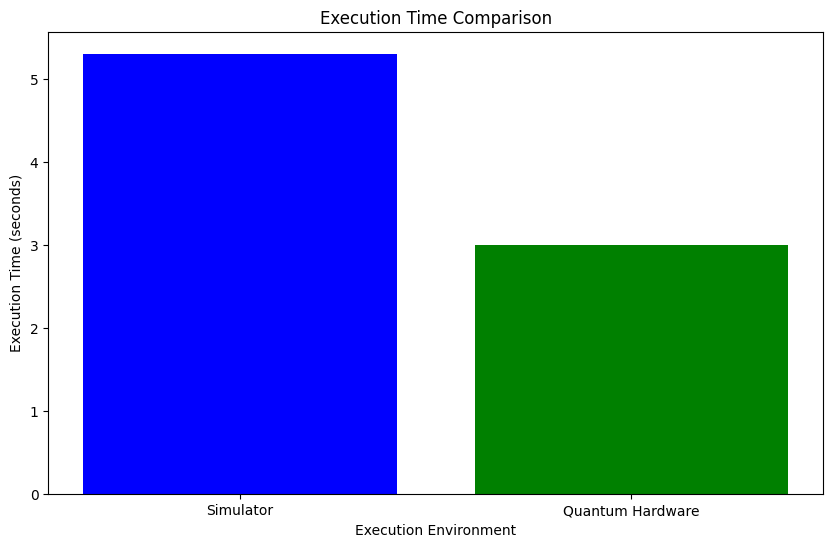

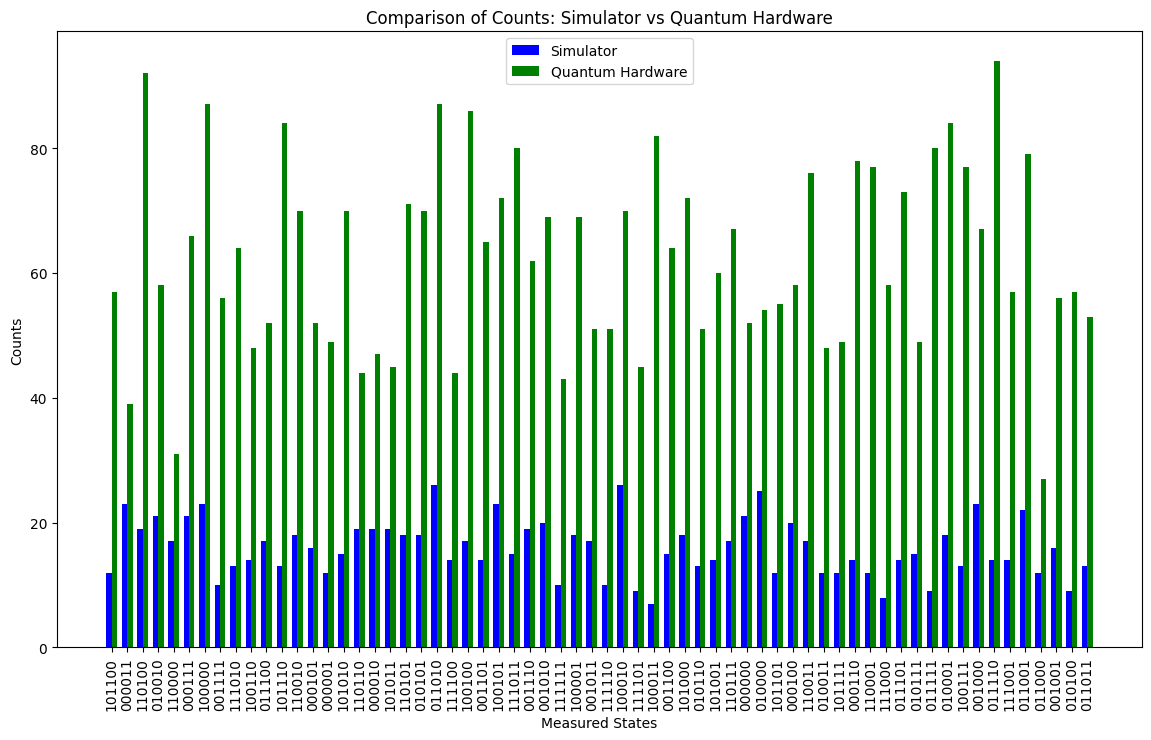

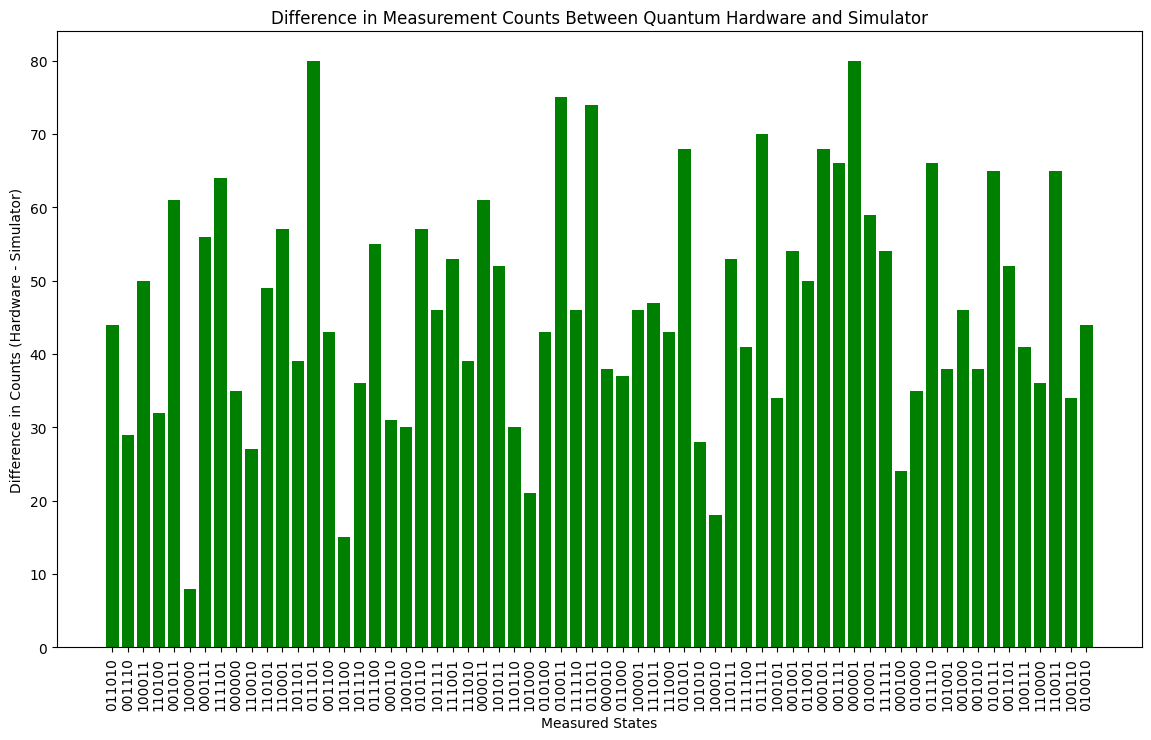

In [22]:
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
import numpy as np

# Sample data (replace with actual counts and times from the execution)
simulator_time = 5.3  # Replace with actual time
hardware_time = 3.0  # Replace with actual time
counts_simulator ={'101100': 12, '000011': 23, '110100': 19, '010010': 21, '110000': 17, '000111': 21, '100000': 23, '001111': 10, '111010': 13, '100110': 14, '011100': 17, '101110': 13, '110010': 18, '000101': 16, '000001': 12, '101010': 15, '110110': 19, '000010': 19, '101011': 19, '110101': 18, '010101': 18, '011010': 26, '111100': 14, '100100': 17, '001101': 14, '100101': 23, '111011': 15, '001110': 19, '001010': 20, '111111': 10, '100001': 18, '001011': 17, '111110': 10, '100010': 26, '111101': 9, '100011': 7, '001100': 15, '101000': 18, '010110': 13, '101001': 14, '110111': 17, '000000': 21, '010000': 25, '101101': 12, '000100': 20, '110011': 17, '010011': 12, '101111': 12, '000110': 14, '110001': 12, '111000': 8, '011101': 14, '010111': 15, '011111': 9, '010001': 18, '100111': 13, '001000': 23, '011110': 14, '111001': 14, '011001': 22, '011000': 12, '001001': 16, '010100': 9, '011011': 13}
counts_hardware = {'000010': 57, '101000': 39, '000001': 92, '101111': 58, '100000': 31, '001101': 66, '010011': 87, '111110': 56, '111111': 64, '001110': 48, '101001': 52, '000101': 84, '110111': 70, '111010': 52, '110110': 49, '010110': 70, '100010': 44, '100100': 47, '110010': 45, '101011': 71, '011010': 70, '011011': 87, '000100': 44, '010101': 86, '010010': 65, '011100': 72, '010111': 80, '111011': 62, '110001': 69, '101010': 43, '001000': 69, '101101': 51, '111000': 51, '001001': 70, '000110': 45, '110011': 82, '100001': 64, '011001': 72, '110100': 51, '010000': 60, '110101': 67, '010100': 52, '100111': 54, '111100': 55, '001010': 58, '001111': 76, '100110': 48, '011000': 49, '001011': 78, '000111': 77, '001100': 58, '111101': 73, '101110': 49, '011110': 80, '000011': 84, '010001': 77, '111001': 67, '011101': 94, '100011': 57, '011111': 79, '101100': 27, '000000': 56, '100101': 57, '110000': 53}
# Time comparison
plt.figure(figsize=(10, 6))
times = [simulator_time, hardware_time]
labels = ['Simulator', 'Quantum Hardware']
plt.bar(labels, times, color=['blue', 'green'])
plt.xlabel('Execution Environment')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time Comparison')
plt.show()

# Results comparison with different colors for simulator and hardware
plt.figure(figsize=(14, 8))
bar_width = 0.35
index = np.arange(len(counts_simulator))
simulator_bar = plt.bar(index, counts_simulator.values(), bar_width, color='blue', label='Simulator')
hardware_bar = plt.bar(index + bar_width, counts_hardware.values(), bar_width, color='green', label='Quantum Hardware')

plt.xlabel('Measured States')
plt.ylabel('Counts')
plt.title('Comparison of Counts: Simulator vs Quantum Hardware')
plt.xticks(index + bar_width / 2, counts_simulator.keys(), rotation=90)
plt.legend()
plt.show()

# Statistical comparison: Difference between counts
all_keys = set(counts_simulator.keys()).union(set(counts_hardware.keys()))
differences = {key: counts_hardware.get(key, 0) - counts_simulator.get(key, 0) for key in all_keys}

# Plot the difference in counts
plt.figure(figsize=(14, 8))
colors = ['red' if differences[key] < 0 else 'green' for key in differences]
plt.bar(differences.keys(), differences.values(), color=colors)
plt.xlabel('Measured States')
plt.ylabel('Difference in Counts (Hardware - Simulator)')
plt.title('Difference in Measurement Counts Between Quantum Hardware and Simulator')
plt.xticks(rotation=90)
plt.show()


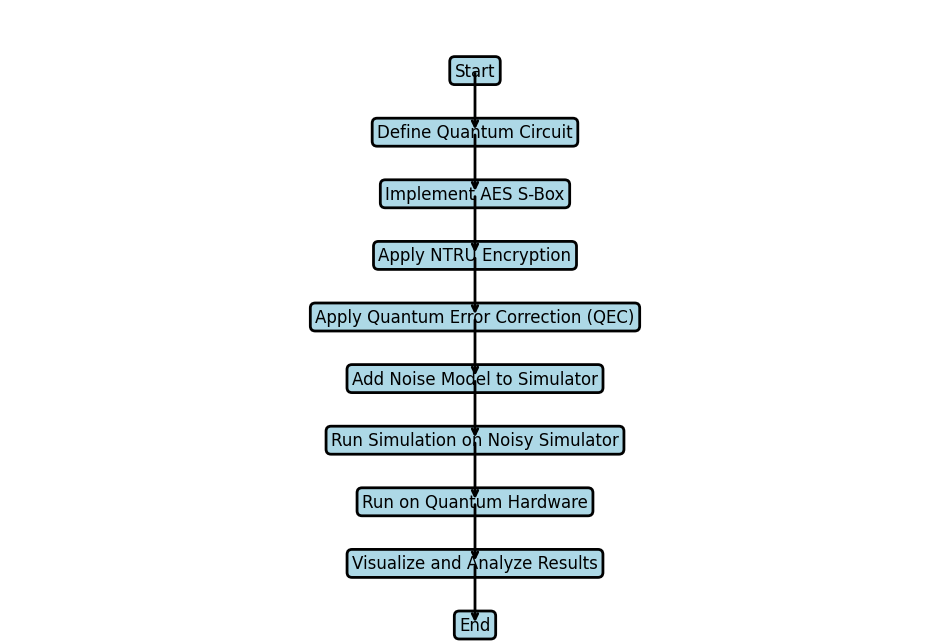

In [23]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# Create a new figure
fig, ax = plt.subplots(figsize=(12, 8))

# Define text and positions for the boxes
boxes = [
    {"text": "Start", "xy": (0.5, 0.9)},
    {"text": "Define Quantum Circuit", "xy": (0.5, 0.8)},
    {"text": "Implement AES S-Box", "xy": (0.5, 0.7)},
    {"text": "Apply NTRU Encryption", "xy": (0.5, 0.6)},
    {"text": "Apply Quantum Error Correction (QEC)", "xy": (0.5, 0.5)},
    {"text": "Add Noise Model to Simulator", "xy": (0.5, 0.4)},
    {"text": "Run Simulation on Noisy Simulator", "xy": (0.5, 0.3)},
    {"text": "Run on Quantum Hardware", "xy": (0.5, 0.2)},
    {"text": "Visualize and Analyze Results", "xy": (0.5, 0.1)},
    {"text": "End", "xy": (0.5, 0.0)},
]

# Draw the boxes
for box in boxes:
    bbox_props = dict(boxstyle="round,pad=0.3", ec="black", fc="lightblue", lw=2)
    t = ax.text(box["xy"][0], box["xy"][1], box["text"], ha="center", va="center", fontsize=12, bbox=bbox_props)

# Draw the arrows
for i in range(len(boxes) - 1):
    ax.annotate("", xy=boxes[i+1]["xy"], xytext=boxes[i]["xy"],
                arrowprops=dict(arrowstyle="->", lw=2))

# Hide axes
ax.axis("off")

# Display the flowchart
plt.show()
